In [1]:
%matplotlib inline
import pylab as plt
import numpy as np
from astrometry.util.fits import *
from collections import Counter
from astrometry.libkd.spherematch import match_radec
import fitsio
from glob import glob
import sys
from astrometry.util.plotutils import *
from astrometry.util.starutil import *
from scipy.ndimage import label, find_objects
from collections import Counter
from tractor import NanoMaggies
from astrometry.util.util import *

In [116]:
#fn = '/pscratch/sd/d/dstn/ibis/zpt/2024-05-30/c4d_240601_043511_ooi_M464_ibis1-photom.fits'
#fn = '/pscratch/sd/d/dstn/ibis/zpt/2024-05-30/c4d_240601_001413_ooi_M411_ibis1-photom.fits'
T = fits_table(fn)
A = fits_table(fn.replace('-photom.fits', '-annotated.fits'))
len(T)

filter = 'M411'
fns = glob('/pscratch/sd/d/dstn/ibis/zpt/2024-05-30/c4d_*_%s_*-photom.fits' % filter)
T = merge_tables([fits_table(fn) for fn in fns])
len(T)

309951

In [118]:
T.about()

tabledata object with 309951 rows and 51 columns:
   airmass (<class 'numpy.ndarray'>) shape (309951,) dtype float32
   apflux_6 (<class 'numpy.ndarray'>) shape (309951,) dtype float32
   apflux_6_err (<class 'numpy.ndarray'>) shape (309951,) dtype float32
   apflux_7 (<class 'numpy.ndarray'>) shape (309951,) dtype float32
   apflux_7_err (<class 'numpy.ndarray'>) shape (309951,) dtype float32
   apflux_8 (<class 'numpy.ndarray'>) shape (309951,) dtype float32
   apflux_8_err (<class 'numpy.ndarray'>) shape (309951,) dtype float32
   bitmask (<class 'numpy.ndarray'>) shape (309951,) dtype uint16
   ccdname (<class 'numpy.ndarray'>) shape (309951,) dtype <U4
   chi2 (<class 'numpy.ndarray'>) shape (309951,) dtype float32
   dec (<class 'numpy.ndarray'>) shape (309951,) dtype float64
   dec_fit (<class 'numpy.ndarray'>) shape (309951,) dtype float64
   dec_gaia (<class 'numpy.ndarray'>) shape (309951,) dtype float64
   dec_now (<class 'numpy.ndarray'>) shape (309951,) dtype float64
   de

In [41]:
a = A[0]
expnum = a.expnum
filter = a.filter
a.object, a.exptime, a.psfdepth, a.expnum, a.filter, a.fwhm * 0.262

('IBIS_deep_cosmos_M411_11',
 407.0,
 23.459492,
 1301441,
 'M411',
 1.5638526029586792)

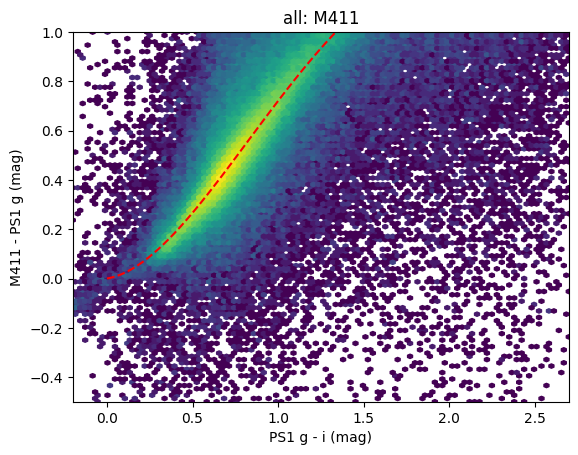

In [117]:
I = np.flatnonzero((T.ps1_g != 0) * (T.ps1_i != 0))
#plt.plot((T.ps1_g - T.ps1_i)[I], (T.psfmag - T.ps1_g)[I], 'b.', alpha=0.05)
ext = [-0.2, 2.7, -0.5, 1]
plt.hexbin((T.ps1_g - T.ps1_i)[I], (T.psfmag - T.ps1_g)[I], extent=ext,
          C=np.ones(len(I)), reduce_C_function=lambda x: np.log10(np.sum(x)+1))
#plt.ylim(-1, +2)
#plt.title('Expnum %i: %s' % (expnum, filter))
plt.title('all: %s' % (filter))
plt.xlabel('PS1 g - i (mag)')
plt.ylabel('%s - PS1 g (mag)' % filter)
#ax = plt.axis()
gi = np.linspace(0., 3., 100)
coeffs = dict(M411 = [0, 0.1164,  1.1036, -0.5814,  0.0817],
              M464 = [0, 0.6712, -0.9042,  0.4621, -0.0737])
m = np.zeros_like(gi)
for i,c in enumerate(coeffs[filter]):
    m += c * gi**i
plt.plot(gi, m, 'r--')
#plt.axis(ax)
#plt.xlim(-0.2, 2.7)
plt.axis(ext)
#plt.savefig('phot2.png')
plt.savefig('phot1.png')

In [119]:
A = fits_table('ibis/ccds-annotated-ibis-1.fits')
Counter(A.filter)

Counter({'M464': 4697, 'M411': 732, '': 1})

In [120]:
A.cut(A.filter != '')
len(A)

5429

In [122]:
A.cut(A.exptime > 30)
A.cut(A.dec > -5)
len(A)

5063

In [123]:
_,I = np.unique(A.expnum, return_index=True)
E = A[I]
bands = np.unique(E.filter)
len(E)

83

90th/95th percentile zpt for M411 : [22.77183914 22.7775589 ]
90th/95th percentile zpt for M464 : [23.49771137 23.501828  ]


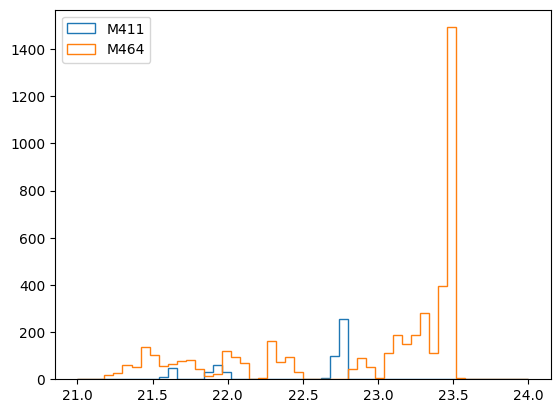

In [141]:
for band in bands:
    I = np.flatnonzero(A.filter == band)
    print('90th/95th percentile zpt for', band, ':', np.percentile(A.ccdzpt[I], [90,95]))
    plt.hist(A.ccdzpt[I], bins=50, range=(21,24), histtype='step', label=band);
plt.legend();

90th/95th percentile zpt for M411 : [22.83669319 22.84161644]
90th/95th percentile zpt for M464 : [23.53149185 23.53479385]


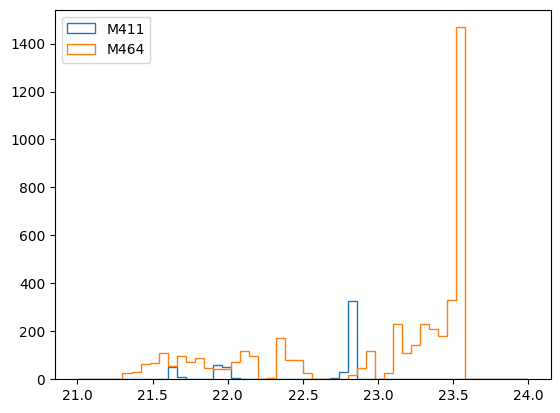

In [150]:
# Airmass-corrected zpt


for band in bands:
    I = np.flatnonzero(A.filter == band)

    # HACK
    kx = 0.17

    zpt = A.ccdzpt[I] + kx * (A.airmass[I] - 1.)
    print('90th/95th percentile zpt for', band, ':', np.percentile(zpt, [90,95]))
    plt.hist(zpt, bins=50, range=(21,24), histtype='step', label=band);
plt.legend();

In [149]:
F = fitsio.FITS('ibis/images/2024-05-30/c4d_240601_033946_ooi_M411_ibis1.fits.fz')
gainmap = {}
for i in range(1, len(F)):
    hdr = F[i].read_header()
    ccd = hdr['EXTNAME']
    gaina = hdr['GAINA']
    gainb = hdr['GAINB']
    gainmap[ccd] = (gaina + gainb)/2.
A.gain = np.array([gainmap[c] for c in A.ccdname])

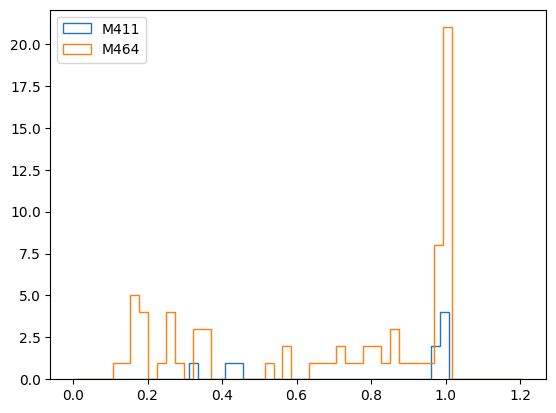

In [151]:
for ib,band in enumerate(bands):
    I = np.flatnonzero(E.filter == band)
    Eb = E[I]
    #zp0 = dict(M464=23.50, M411=22.78)[band]
    zp0 = dict(M464=23.53, M411=22.84)[band]
    kx  = dict(M464=0.17,  M411=0.17) [band]
    Eb.transparency = 10.**(-0.4 * (zp0 - Eb.ccdzpt - kx * (Eb.airmass - 1.)))
    plt.hist(Eb.transparency, range=(0 + 0.01*ib, 1.2 + 0.01*ib), bins=50, histtype='step', label=band)
plt.legend();

In [183]:
A.zp0 = np.array([dict(M464=23.53, M411=22.84)[band] for band in A.filter])
A.kx  = np.array([dict(M464=0.17,  M411=0.17) [band] for band in A.filter])
A.transparency = 10.**(-0.4 * (A.zp0 - A.ccdzpt - A.kx * (A.airmass - 1.)))

In [155]:
def Neff(seeing):
    #r_half = 0.45 #arcsec
    r_half = 0.15 #arcsec
    ps = 0.262
    # magic 2.35: convert seeing FWHM into sigmas in arcsec.
    return (4. * np.pi * (seeing / 2.35)**2 +
            8.91 * r_half**2 +
            ps**2/12.)

In [176]:
A.neff = np.array([Neff(fwhm * 0.262) for fwhm in A.fwhm])

neff_fid = Neff(1.25)

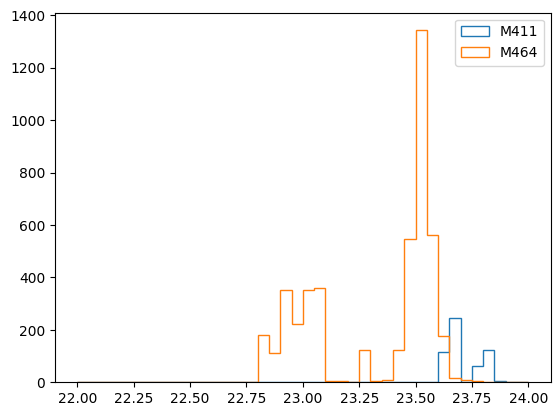

In [182]:
for band in bands:
    I = np.flatnonzero(A.filter == band)
    plt.hist(A.ccdskysb[I], label=band, histtype='step', range=(22,24), bins=40);
plt.legend();

In [185]:
# ????
A.nom_sky = np.array([dict(M464=23.50, M411=23.75)[band] for band in A.filter])
# dust extinction coeff
A.A_co = np.array([dict(M464=3.214, M411=3.214)[band] for band in A.filter])

In [187]:
scaling = (1./A.transparency**2 *
            10.**(0.8 * A.kx * (A.airmass - 1.)) *
            10.**(0.8 * A.A_co * A.ebv) *
            (A.neff / neff_fid) *
            10.**(-0.4 * (A.ccdskysb - A.nom_sky)))

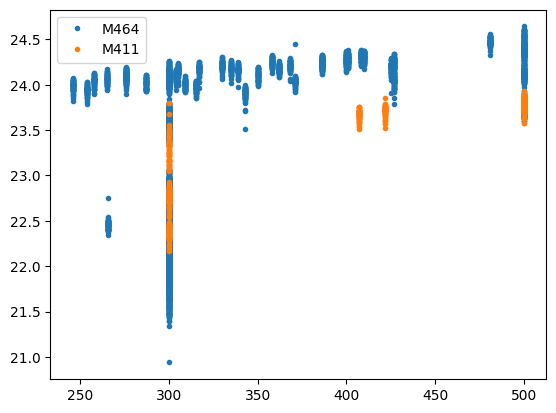

In [190]:
for band in reversed(bands):
    I = np.flatnonzero(A.filter == band)
    plt.plot(A.exptime[I], A.gausspsfdepth[I], '.', label=band)
plt.legend();

/tmp/ipykernel_2117810/2141599177.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(A.exptime[I] / scaling[I], A.gausspsfdepth[I], '.', label=band, alpha=0.2)


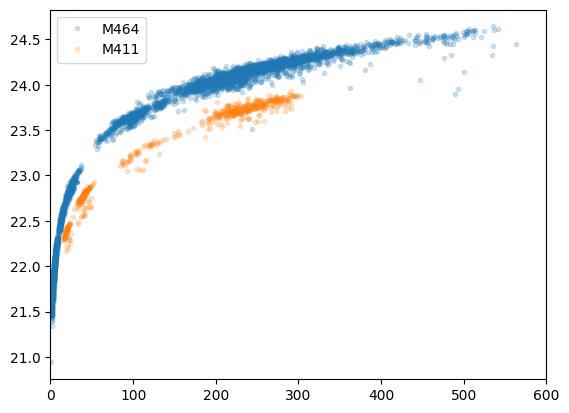

In [195]:
for band in reversed(bands):
    I = np.flatnonzero(A.filter == band)
    plt.plot(A.exptime[I] / scaling[I], A.gausspsfdepth[I], '.', label=band, alpha=0.2)
plt.legend();
plt.xlim(0, 600);

/tmp/ipykernel_2117810/2487412728.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(A.exptime[I] / scaling[I], depth, '.', label=band, alpha=0.2)


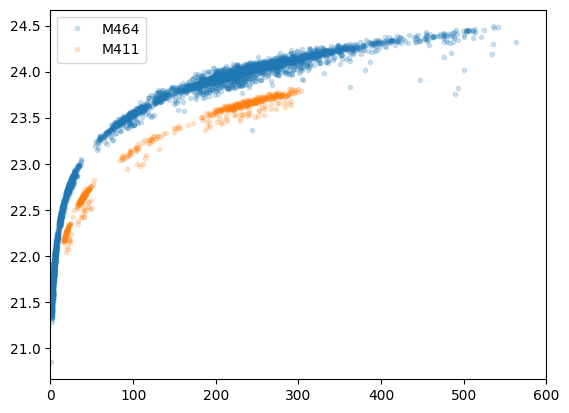

In [228]:
for band in reversed(bands):
    I = np.flatnonzero(A.filter == band)
    depth = A.gausspsfdepth[I] - A.ebv[I] * A.A_co[I]
    plt.plot(A.exptime[I] / scaling[I], depth, '.', label=band, alpha=0.2)
plt.legend();
plt.xlim(0, 600);

/tmp/ipykernel_2117810/178961280.py:4: RuntimeWarning: divide by zero encountered in divide
  A.efftime = A.exptime / scaling


Target efftime for M464 : 242.0 s
Target efftime for M411 : 492.0 s


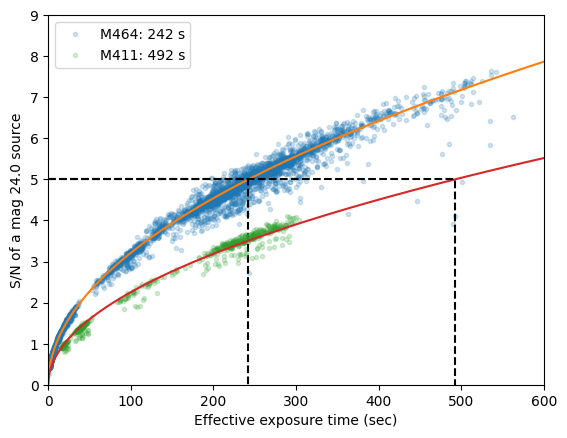

In [229]:
tt = np.linspace(0, 600, 601)
templ_sn = np.sqrt(tt)

A.efftime = A.exptime / scaling

for band in reversed(bands):
    I = np.flatnonzero(A.filter == band)
    
    target_depth = 24.03
    target_sn = 5.0

    depth = A.gausspsfdepth[I] - A.ebv[I] * A.A_co[I]

    sn = target_sn * 10.**(0.4 * (depth - target_depth))
    fac = np.median(sn / np.sqrt(A.efftime[I]))
    i = np.argmin(np.abs(templ_sn * fac - target_sn))
    print('Target efftime for', band, ': %.1f s' % tt[i])
    plt.plot(A.efftime[I], sn, '.', label='%s: %i s' % (band, int(np.round(tt[i]))), alpha=0.2)
    plt.plot(tt, templ_sn * fac, '-')
    
    plt.plot([0, tt[i], tt[i]], [target_sn, target_sn, 0], 'k--')
    
plt.xlabel('Effective exposure time (sec)')
plt.ylabel('S/N of a mag %.1f source' % target_depth)
plt.legend();
plt.xlim(0, 600);
plt.ylim(0,9)
plt.savefig('efftime.png')

Target efftime for M464 : 242.0 s
6-pass depth: 25.002193662286352
Target efftime for M411 : 492.0 s
6-pass depth: 25.002607233319345


/tmp/ipykernel_2117810/1394412646.py:24: RuntimeWarning: divide by zero encountered in log10
  depth_fit = target_depth + 2.5*np.log10(templ_sn * fac / target_sn)


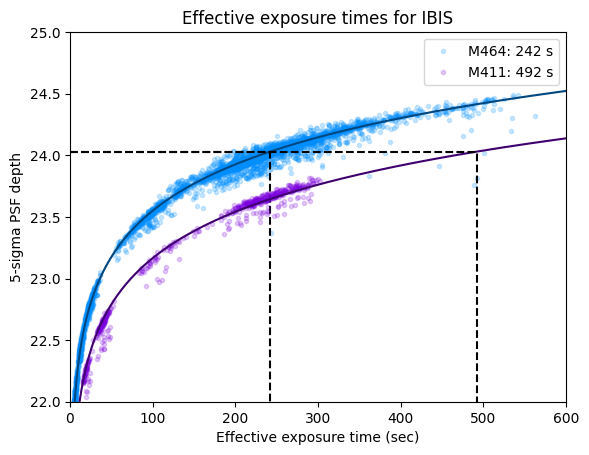

In [230]:
tt = np.linspace(0, 600, 601)
templ_sn = np.sqrt(tt)

colors = dict(M411=(124/255,0,222/255),
              M464=(0, 142/255, 255/255))
colors2 = dict(M411=np.array((124/255,0,222/255))/2.,
              M464=np.array((0, 142/255, 255/255))/2.)

for band in reversed(bands):
    I = np.flatnonzero(A.filter == band)
    
    target_depth = 24.03
    target_sn = 5.0

    depth = A.gausspsfdepth[I] - A.ebv[I] * A.A_co[I]

    sn = target_sn * 10.**(0.4 * (depth - target_depth))
    fac = np.median(sn / np.sqrt(A.efftime[I]))
    i = np.argmin(np.abs(templ_sn * fac - target_sn))
    print('Target efftime for', band, ': %.1f s' % tt[i])
    plt.plot(A.efftime[I], depth, '.', label='%s: %i s' % (band, int(np.round(tt[i]))), alpha=0.2,
            color=colors[band])

    depth_fit = target_depth + 2.5*np.log10(templ_sn * fac / target_sn)
    plt.plot(tt, depth_fit, '-', color=colors2[band])
    
    plt.plot([0, tt[i], tt[i]], [target_depth, target_depth, 0], 'k--')

    print('6-pass depth:', target_depth + 2.5 * np.log10((np.sqrt(tt[i] * 6) * fac / target_sn)))

plt.xlabel('Effective exposure time (sec)')
plt.ylabel('5-sigma PSF depth')
plt.legend();
plt.xlim(0, 600);
plt.ylim(22,25)
plt.title('Effective exposure times for IBIS')
plt.savefig('efftime2.png')

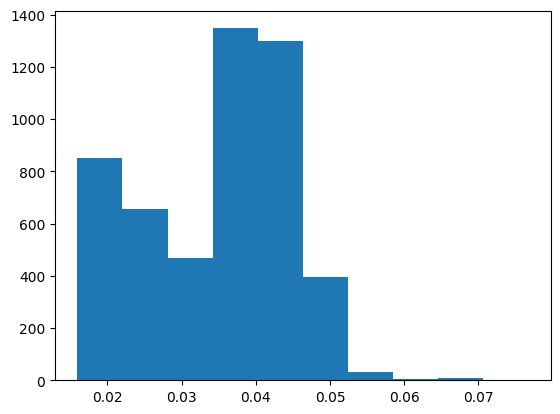

In [226]:
plt.hist(A.ebv);

In [108]:
#np.unique(A.object)
_,I = np.unique(A.expnum, return_index=True)
E = A[I]
bands = np.unique(E.filter)
for band in bands:
    I = np.flatnonzero(E.filter == band)
    Eb = E[I]
    I = np.argsort(Eb.psfdepth)
    for i in I:
        print('%.2f in %s : expnum %i : %s : %s' % (Eb.psfdepth[i], Eb.filter[i], Eb.expnum[i], Eb.image_filename[i], Eb.object[i]))

20.84 in M411 : expnum 1301480 : 2024-05-30/c4d_240601_033906_ooi_M411_ibis1.fits.fz : LTT6248 M411 S4
20.91 in M411 : expnum 1301479 : 2024-05-30/c4d_240601_033828_ooi_M411_ibis1.fits.fz : LTT6248 M411 N4
21.91 in M411 : expnum 1301481 : 2024-05-30/c4d_240601_033946_ooi_M411_ibis1.fits.fz : LTT6248 M411 S4
22.24 in M411 : expnum 1301169 : 2024-05-30/c4d_240531_014913_ooi_M411_ibis1.fits.fz : IBIS_deep_desi220_M464_1
22.51 in M411 : expnum 1301173 : 2024-05-30/c4d_240531_020321_ooi_M411_ibis1.fits.fz : IBIS_deep_desi220_M464_2
22.59 in M411 : expnum 1301172 : 2024-05-30/c4d_240531_015751_ooi_M411_ibis1.fits.fz : IBIS_deep_desi220_M464_3
22.89 in M411 : expnum 1301438 : 2024-05-30/c4d_240601_000403_ooi_M411_ibis1.fits.fz : IBIS_deep_cosmos_M411_10
23.46 in M411 : expnum 1301441 : 2024-05-30/c4d_240601_001413_ooi_M411_ibis1.fits.fz : IBIS_deep_cosmos_M411_11
23.52 in M411 : expnum 1301445 : 2024-05-30/c4d_240601_004649_ooi_M411_ibis1.fits.fz : IBIS_deep_cosmos_M411_15
23.52 in M411 : exp

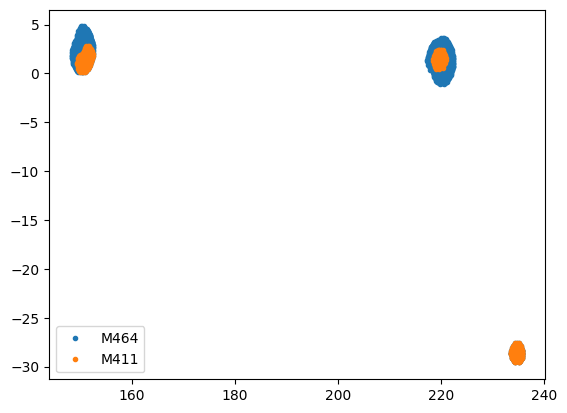

In [49]:
for f in reversed(np.unique(A.filter)):
    I = np.flatnonzero(A.filter == f)
    plt.plot(A.ra[I], A.dec[I], '.', label=f)
plt.legend();

In [72]:
nr,nd = 500,500
rc,dc = 220, 1.2
rrad = 2.5
drad = 2.5
rr = np.linspace(rc-rrad, rc+rrad, nr)
dd = np.linspace(dc-drad, dc+drad, nd)
rr,dd = np.meshgrid(rr, dd)

In [73]:
dra,ddec = 4096 * 0.262/3600./2, 2048 * 0.262/3600./2
bands = np.unique(A.filter)
psfdepths = dict([(k,np.zeros(len(rr.ravel()), np.float32)) for k in bands])
A.psfdepth_ivar = (5. / (10.**((A.psfdepth / -2.5) + 9.)))**2

for band in bands:
    print('Band', band)
    Ib = np.flatnonzero(A.filter == band)
    I = match_radec(rr.ravel(), dd.ravel(), A.ra[Ib], A.dec[Ib], 0.17, indexlist=True)
    pd = psfdepths[band]
    mm = []
    for j,(ii,ra,dec) in enumerate(zip(I, rr.ravel(), dd.ravel())):
        if ii is None:
            continue
        ii = Ib[ii]
        ii = ii[(np.abs(A.ra[ii] - ra) * np.cos(np.deg2rad(A.dec[ii])) < dra) *
                (np.abs(A.dec[ii] - dec) < ddec)]
        pd[j] += np.sum(A.psfdepth_ivar[ii])
        mm.append(A.psfdepth[ii])

Band M411
Band M464


/tmp/ipykernel_2117810/1193318730.py:3: RuntimeWarning: divide by zero encountered in divide
  pd = -2.5 * (np.log10(5. / np.sqrt(pd)) - 9)


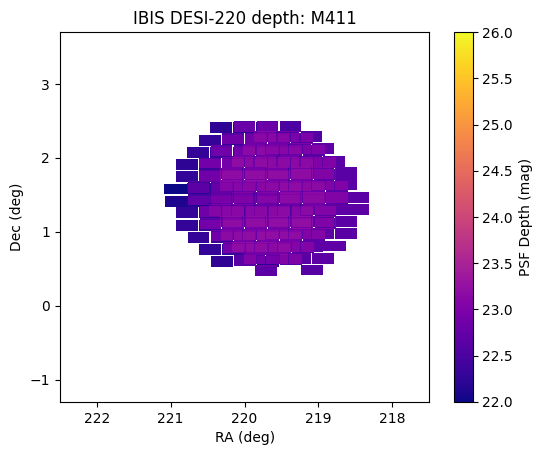

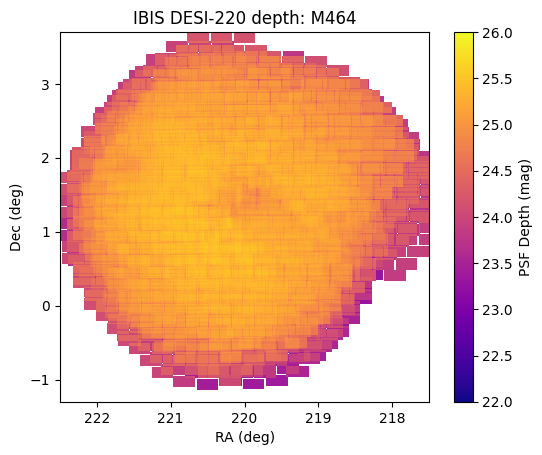

In [77]:
for band in bands:
    pd = psfdepths[band]
    pd = -2.5 * (np.log10(5. / np.sqrt(pd)) - 9)
    pdmap = np.zeros(rr.shape, np.float32)
    ok = np.ones(rr.ravel().shape, bool)
    pdmap.flat[ok] = pd
    pdmap.flat[~ok] = np.nan
    plt.clf()
    plt.imshow(pdmap, origin='lower', interpolation='nearest', vmin=22, vmax=26, cmap='plasma',
              extent=(rr.min(), rr.max(), dd.min(), dd.max()))
    cb = plt.colorbar()
    cb.set_label('PSF Depth (mag)')
    xl,xh = plt.xlim()
    plt.xlim(xh,xl)
    plt.xlabel('RA (deg)')
    plt.ylabel('Dec (deg)')
    plt.title('IBIS DESI-220 depth: %s' % band)
    plt.savefig('depth-%s.png' % band)
    plt.show()    

In [84]:
Counter(A.ccd_cuts).most_common()

[(0, 5176), (32776, 241), (2048, 5), (131072, 3), (34824, 3), (131104, 1)]